In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce

In [2]:
df=pd.read_csv('src/data/PID5298d653-d5b6-49ac-ac4a-2565405baa8e.csv')

In [3]:
df.head()

,Unnamed: 0,_id,Unnamed: 0.1,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,616c4ac462394923cf69ec26,0,1,2,20,RL,80.0,9600,Pave,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
1,1,616c4ac462394923cf69ec27,1,2,3,60,RL,68.0,11250,Pave,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
2,2,616c4ac462394923cf69ec2a,2,5,6,50,RL,85.0,14115,Pave,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
3,3,616c4ac462394923cf69ec31,3,12,13,20,RL,NaN,12968,Pave,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
4,4,616c4ac462394923cf69ec35,4,16,17,20,RL,NaN,11241,Pave,...,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000


In [34]:
onehot = ce.OneHotEncoder(cols=['MSZoning'])
onehot_df = onehot.fit_transform(df.loc[:,['MSZoning']])

In [35]:
onehot_df

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1455,0,1,0,0,0
1456,0,1,0,0,0
1457,1,0,0,0,0
1458,1,0,0,0,0


In [36]:
from pickle import dump,load
dump(onehot, open('onehot_df.pkl', 'wb'))

In [37]:
# load the model
onehot_df = load(open('onehot_df.pkl', 'rb'))
onehot_df.transform(df.loc[:,['MSZoning']])

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1455,0,1,0,0,0
1456,0,1,0,0,0
1457,1,0,0,0,0
1458,1,0,0,0,0


In [20]:
onehot.generate_mapping()

[{'col': 'MSZoning',
  'mapping':     MSZoning_1  MSZoning_2  MSZoning_3  MSZoning_4  MSZoning_5
   1           1           0           0           0           0
   2           0           1           0           0           0
   3           0           0           1           0           0
   4           0           0           0           1           0
   5           0           0           0           0           1
  -1           0           0           0           0           0
  -2           0           0           0           0           0}]

In [30]:
target = ce.OrdinalEncoder(cols=['MSZoning'])
target_df = target.fit_transform(df.loc[:,['MSZoning']])


SpecificationError: nested renamer is not supported

In [27]:
target.category_mapping()

TypeError: 'list' object is not callable

In [44]:
def target_class_ratio(dataframe, target_col):
    try:
        target_class_ratio_dict = {'Classes' : [], 'Class_count' : [], 'Class_percent' : []}
        print(dataframe[target_col].value_counts())
        labels = dict(dataframe[target_col].value_counts())

        for label in labels:
            target_class_ratio_dict['Classes'].append(label)
            target_class_ratio_dict['Class_count'].append(labels[label])
            target_class_ratio_dict['Class_percent'].append(round(labels[label]/dataframe.shape[0] * 100, 2))

        return pd.DataFrame(target_class_ratio_dict, columns=['Classes', 'Class_count', 'Class_percent'])
    except Exception as e:
        print(str(e))

In [19]:
imbalanced_report = target_class_ratio(df, "Label")

<AxesSubplot:xlabel='Classes'>

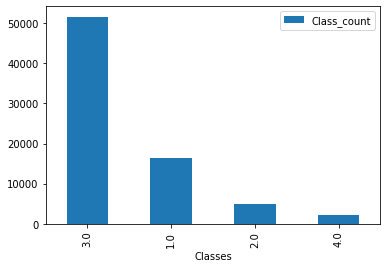

In [21]:
imbalanced_report.plot.bar(x='Classes', y='Class_count')

In [45]:
from imblearn.under_sampling import NearMiss

def under_sample(dataframe, target_col, ratio=None):
    
    X = dataframe.drop(columns=[target_col])
    y = dataframe[target_col]
    
    if ratio:
        try:
            ns=NearMiss(sampling_strategy=ratio)
            X_resampled, y_resampled = ns.fit_resample(X, y)
        except ValueError as e:
            return e
    else:  
        ns=NearMiss()
        X_resampled, y_resampled = ns.fit_resample(X, y)
    
    resampled_dataset = X_resampled.join(y_resampled)
        
    return resampled_dataset 

3.0    5000
1.0    5000
2.0    4909
4.0    2289
Name: Label, dtype: int64


<AxesSubplot:xlabel='Classes'>

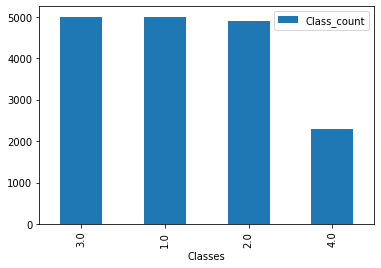

In [35]:
resampled = under_sample(df, 'Label', {3.0:5000, 1.0:5000})
target_class_ratio(resampled, "Label").plot.bar(x='Classes', y='Class_count')

In [52]:
from imblearn.over_sampling import RandomOverSampler

def over_sample(dataframe, target_col, ratio=None):
    
    X = dataframe.drop(columns=[target_col])
    y = dataframe[target_col]
    
    if ratio:
        try:
            ros = RandomOverSampler(sampling_strategy=ratio)
            X_resampled, y_resampled = ros.fit_resample(X, y)
        except Exception as e:
            print(str(e))
            return e
    else:  
        ros = RandomOverSampler()
        X_resampled, y_resampled = ros.fit_resample(X, y)
    
    resampled_dataset = X_resampled.join(y_resampled)
        
    return resampled_dataset 

4.0    55000
3.0    55000
2.0    55000
1.0    55000
Name: Label, dtype: int64


C:\Users\pankaj\anaconda3\envs\projectathon\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (55000) in class 1.0 will be larger than the number of samples in the majority class (class #3.0 -> 51515)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\pankaj\anaconda3\envs\projectathon\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (55000) in class 2.0 will be larger than the number of samples in the majority class (class #3.0 -> 51515)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\pankaj\anaconda3\envs\projectathon\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (55000) in class 3.0 will be larger than the number of samples in the majority class (class #3.0 -> 51515)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\pankaj\anaconda3\envs\pro

<AxesSubplot:xlabel='Classes'>

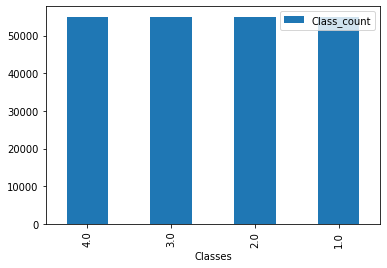

In [56]:
target_class_ratio(over_sample(df, "Label", {1.0:55000, 2.0:55000,3.0:55000,4.0:55000}), "Label").plot.bar(x='Classes', y='Class_count')

##### df.to_csv('data.csv')